In [ ]:
#Code to find the Stackelberg Equilibria of a Pricing Game

In [1]:
import matplotlib.pyplot as plt


In [2]:


import numpy as np
from scipy.optimize import linprog

from operator import add, neg



def precise_stackelberg_equilibrium_old(leader_payoff_matrix, follower_payoff_matrix):
  num_leader_actions = leader_payoff_matrix.shape[0]
  num_follower_actions = leader_payoff_matrix.shape[1]

  # Define the constraint matrix A_ub and the right-hand side b_ub
  A_ub = np.zeros((num_follower_actions + 2, num_leader_actions))
  b_ub = np.zeros(num_follower_actions + 2)
  bounds = [(0, 1) for _ in range(num_leader_actions)]
  best_leader_payoff = np.min(leader_payoff_matrix)
  best_leader_strategy = np.zeros(num_leader_actions)

  for benchmark_follower_action in range(num_follower_actions):
    row_index = 0
    c_leader = -leader_payoff_matrix[:, benchmark_follower_action]  # maximize leader's payoff when follower plays a particular action
    for i in range(num_follower_actions):
      A_ub[row_index] = follower_payoff_matrix.T[i] - follower_payoff_matrix.T[benchmark_follower_action]
      b_ub[row_index] = 0
      row_index = row_index + 1

    A_ub[row_index] = np.ones(num_leader_actions)
    b_ub[row_index] = 1
    row_index = row_index + 1
    A_ub[row_index] = -1 * np.ones(num_leader_actions)
    b_ub[row_index] = -1

    # Solve the linear programming problem
    result = linprog(c_leader, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    print(result.status)

    # Extract the solution
    leader_optimal_strategy = result.x

    # compare different LPs for different optimizer actions
    follower_benchmark_distribution = np.zeros(num_follower_actions)
    follower_benchmark_distribution[benchmark_follower_action] = 1
    leader_payoff = evaluate_leader_payoff(leader_payoff_matrix, leader_optimal_strategy, follower_benchmark_distribution)
    if (leader_payoff >= best_leader_payoff):
      best_leader_payoff = leader_payoff
      best_leader_strategy = leader_optimal_strategy
      follower_response = benchmark_follower_action
  return best_leader_payoff, best_leader_strategy, follower_response


def precise_stackelberg_value(leader_payoff_matrix, follower_payoff_matrix):
    (val,_,_) = precise_stackelberg_equilibrium(leader_payoff_matrix, follower_payoff_matrix)
    return val

# code for computing mnse from https://github.com/sid230798/Game_Theory/blob/master/Problem3/analyse_equilibrium.py
def msne(a):
    a = a.T
    ## One zero array for later (z, x)
    ess = np.ones(a.shape[0]+1)
    ess[0] = 0

    c = -1*(1-ess)  ##[-1, 0 ,0 ,0] -1 coeff for z and 0 for x (Max z == min(-z))
    A_ub = np.concatenate((np.ones((1, a.shape[1])), -1*a), axis=0).T
    B_ub = np.zeros(a.shape[1])
    A_eq = np.expand_dims(ess, axis=0)
    B_eq = np.ones(1)
    bounds = [(None, None)] + [(0,1)]*a.shape[0]
    result = linprog(c, A_ub=A_ub, b_ub=B_ub, A_eq=A_eq, b_eq=B_eq, bounds=bounds)
    p1_val, p1_distribution = result.x[0], result.x[1:]

    ## For 2nd player distribution
    ess = np.ones(a.shape[1]+1)
    ess[0] = 0
    c = (1-ess)
    A_ub = np.concatenate((-1*np.ones((a.shape[0], 1)), a), axis=1)
    B_ub = np.zeros(a.shape[0])
    A_eq = np.expand_dims(ess, axis=0)
    A_eq = np.concatenate((A_eq, 1-A_eq), axis=0)
    B_eq = np.array([1, p1_val]) ## Dual Principle w* = z*
    bounds = [(None, None)] + [(0,1)]*a.shape[1]
    result = linprog(c, A_ub=A_ub, b_ub=B_ub, A_eq=A_eq, b_eq=B_eq, bounds=bounds)
    p2_val, p2_distribution = result.x[0], result.x[1:]

    print("MSNE are : {", tuple(p1_distribution), "," ,tuple(p2_distribution), "}")

def maxmin(a):
    a = a.T
    print(a)
    ## One zero array for later (z, x)
    ess = np.ones(a.shape[0]+1)
    ess[0] = 0

    c = -1*(1-ess)  ##[-1, 0 ,0 ,0] -1 coeff for z and 0 for x (Max z == min(-z))
    A_ub = np.concatenate((np.ones((1, a.shape[1])), -1*a), axis=0).T
    B_ub = np.zeros(a.shape[1])
    A_eq = np.expand_dims(ess, axis=0)
    B_eq = np.ones(1)
    bounds = [(None, None)] + [(0,1)]*a.shape[0]
    print("data:")
    print(c)
    print(A_ub)
    print(B_ub)
    print(A_eq)
    print(B_eq)
    print(bounds)
    result = linprog(c, A_ub=A_ub, b_ub=B_ub, A_eq=A_eq, b_eq=B_eq, bounds=bounds)
    p1_distribution = result.x[1:]
    return p1_distribution

def transform_game_matrix(game_matrix, mixed_strategies):
    """
    Transforms each game matrix based on the set of mixed strategies. Each mixed strategy
    becomes a new 'pure' strategy in the transformed games for the followers.
    """
    # Convert the distributions list into a NumPy array for easier manipulation
    distributions_array = np.array(mixed_strategies)
    transformed_matrix = np.dot(game_matrix.T, distributions_array.T).T
    return transformed_matrix


def evaluate_leader_payoff_old(game_matrix, leader_strategy, follower_strategy):
    """
    Evaluates the leader's expected payoff on a certain follower game given the leader's strategy and the follower's strategy.
    """
    leader_strategy = np.array(leader_strategy)
    follower_strategy = np.array(follower_strategy)
    expected_payoff = 0
    for leader_strategy, leader_prob in enumerate(leader_strategy):
        for follower_action in range(len(follower_strategy)):
          expected_payoff += leader_prob * follower_strategy[follower_action] * game_matrix[leader_strategy][follower_action]
    return expected_payoff








In [3]:
def evaluate_leader_payoff(game_matrix, leader_strategy, follower_strategy):
    """
    Evaluates the leader's expected payoff given the leader's strategy and the follower's strategy.
    
    Parameters:
    game_matrix (2D numpy array): The leader's payoff matrix
    leader_strategy (1D numpy array): The leader's mixed strategy
    follower_strategy (1D numpy array): The follower's mixed strategy
    
    Returns:
    float: The expected payoff for the leader
    """
    leader_strategy = np.array(leader_strategy)
    follower_strategy = np.array(follower_strategy)
    
    expected_payoff = 0.0
    
    for i in range(len(leader_strategy)):
        for j in range(len(follower_strategy)):
            # Probability of this outcome
            prob = leader_strategy[i] * follower_strategy[j]
            
            # Payoff for the leader in this outcome
            payoff = game_matrix[i][j]
            
            # Add to the expected payoff
            expected_payoff += prob * payoff
    
    return expected_payoff

In [4]:
def precise_stackelberg_equilibrium(leader_payoff_matrix, follower_payoff_matrix):
    num_leader_actions = leader_payoff_matrix.shape[0]
    num_follower_actions = leader_payoff_matrix.shape[1]

    print(f"Number of leader actions: {num_leader_actions}")
    print(f"Number of follower actions: {num_follower_actions}")

    # Define the constraint matrix A_ub and the right-hand side b_ub
    A_ub = np.zeros((num_follower_actions + 2, num_leader_actions))
    b_ub = np.zeros(num_follower_actions + 2)
    bounds = [(0, 1) for _ in range(num_leader_actions)]
    best_leader_payoff = float('-inf')  # Initialize to negative infinity
    best_leader_strategy = np.zeros(num_leader_actions)
    follower_response = None

    for benchmark_follower_action in range(num_follower_actions):
        print(f"\nChecking follower action {benchmark_follower_action}")
        row_index = 0
        c_leader = -leader_payoff_matrix[:, benchmark_follower_action]  # maximize leader's payoff when follower plays a particular action
        for i in range(num_follower_actions):
            A_ub[row_index] = follower_payoff_matrix.T[i] - follower_payoff_matrix.T[benchmark_follower_action]
            b_ub[row_index] = 0
            row_index += 1

        A_ub[row_index] = np.ones(num_leader_actions)
        b_ub[row_index] = 1
        row_index += 1
        A_ub[row_index] = -1 * np.ones(num_leader_actions)
        b_ub[row_index] = -1

        print("Linear programming setup:")
        print(f"c_leader: {c_leader}")
        print(f"A_ub:\n{A_ub}")
        print(f"b_ub: {b_ub}")
        print(f"bounds: {bounds}")

        # Solve the linear programming problem
        result = linprog(c_leader, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
        print(f"LP result status: {result.status}")

        if result.success:
            # Extract the solution
            leader_optimal_strategy = result.x
            print(f"Leader optimal strategy: {leader_optimal_strategy}")

            # compare different LPs for different optimizer actions
            follower_benchmark_distribution = np.zeros(num_follower_actions)
            follower_benchmark_distribution[benchmark_follower_action] = 1
            leader_payoff = np.dot(leader_optimal_strategy, leader_payoff_matrix[:, benchmark_follower_action])

            benchmark_follower_payoff = np.dot(leader_optimal_strategy, follower_payoff_matrix[:, benchmark_follower_action])
            print(f"Leader payoff: {leader_payoff}")

            if leader_payoff > best_leader_payoff:
                best_leader_payoff = leader_payoff
                best_leader_strategy = leader_optimal_strategy
                follower_response = benchmark_follower_action
                follower_payoff = benchmark_follower_payoff
                
        else:
            print(f"Linear programming failed for follower action {benchmark_follower_action}")

    print(f"\nFinal results:")
    print(f"Best leader payoff: {best_leader_payoff}")
    print(f"Best leader strategy: {best_leader_strategy}")
    print(f"Follower response: {follower_response}")
    print(f"Follower payoff: {follower_payoff}")

    return best_leader_payoff, best_leader_strategy, follower_response, follower_payoff

In [5]:
def precise_stackelberg_equilibrium_print_flag(leader_payoff_matrix, follower_payoff_matrix, print_flag=False):
    num_leader_actions = leader_payoff_matrix.shape[0]
    num_follower_actions = leader_payoff_matrix.shape[1]

    if print_flag:
        print(f"Number of leader actions: {num_leader_actions}")
        print(f"Number of follower actions: {num_follower_actions}")

    # Define the constraint matrix A_ub and the right-hand side b_ub
    A_ub = np.zeros((num_follower_actions + 2, num_leader_actions))
    b_ub = np.zeros(num_follower_actions + 2)
    bounds = [(0, 1) for _ in range(num_leader_actions)]
    best_leader_payoff = float('-inf')  # Initialize to negative infinity
    best_leader_strategy = np.zeros(num_leader_actions)
    follower_response = None

    for benchmark_follower_action in range(num_follower_actions):
        if print_flag:
            print(f"\nChecking follower action {benchmark_follower_action}")
        row_index = 0
        c_leader = -leader_payoff_matrix[:, benchmark_follower_action]  # maximize leader's payoff when follower plays a particular action
        for i in range(num_follower_actions):
            A_ub[row_index] = follower_payoff_matrix.T[i] - follower_payoff_matrix.T[benchmark_follower_action]
            b_ub[row_index] = 0
            row_index += 1

        A_ub[row_index] = np.ones(num_leader_actions)
        b_ub[row_index] = 1
        row_index += 1
        A_ub[row_index] = -1 * np.ones(num_leader_actions)
        b_ub[row_index] = -1

        if print_flag:
            print("Linear programming setup:")
            print(f"c_leader: {c_leader}")
            print(f"A_ub:\n{A_ub}")
            print(f"b_ub: {b_ub}")
            print(f"bounds: {bounds}")

        # Solve the linear programming problem
        result = linprog(c_leader, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
        if print_flag:
            print(f"LP result status: {result.status}")

        if result.success:
            # Extract the solution
            leader_optimal_strategy = result.x
            if print_flag:
                print(f"Leader optimal strategy: {leader_optimal_strategy}")

            # compare different LPs for different optimizer actions
            follower_benchmark_distribution = np.zeros(num_follower_actions)
            follower_benchmark_distribution[benchmark_follower_action] = 1
            leader_payoff = np.dot(leader_optimal_strategy, leader_payoff_matrix[:, benchmark_follower_action])

            benchmark_follower_payoff = np.dot(leader_optimal_strategy, follower_payoff_matrix[:, benchmark_follower_action])
            if print_flag:
                print(f"Leader payoff: {leader_payoff}")

            if leader_payoff > best_leader_payoff:
                best_leader_payoff = leader_payoff
                best_leader_strategy = leader_optimal_strategy
                follower_response = benchmark_follower_action
                follower_payoff = benchmark_follower_payoff
        else:
            if print_flag:
                print(f"Linear programming failed for follower action {benchmark_follower_action}")

    if print_flag:
        print(f"\nFinal results:")
        print(f"Best leader payoff: {best_leader_payoff}")
        print(f"Best leader strategy: {best_leader_strategy}")
        print(f"Follower response: {follower_response}")
        print(f"Follower payoff: {follower_payoff}")

    return best_leader_payoff, best_leader_strategy, follower_response, follower_payoff


In [7]:
#Prisoners dilemma game matrix

leader_matrix = np.array([[3, 0],
              [5, 1]])
follower_matrix = np.array([[3, 5],
              [0, 1]])

best_leader_payoff, best_leader_strategy, follower_response, follower_payoff = precise_stackelberg_equilibrium_print_flag(leader_matrix, follower_matrix)

In [8]:


# Battle of the Sexes (with a twist)
leader_matrix = np.array([[3, 0],
                          [0, 2]])
follower_matrix = np.array([[2, 0],
                            [0, 3]])

best_leader_payoff, best_leader_strategy, follower_response, follower_payoff = precise_stackelberg_equilibrium(leader_matrix, follower_matrix)

print("Battle of the Sexes (with a twist)")
print(f"Best leader payoff: {best_leader_payoff}")
print(f"Best leader strategy: {best_leader_strategy}")
print(f"Follower response: {follower_response}")
print(f"Expected: Payoff 3, Strategy [1, 0], Response 0")

Number of leader actions: 2
Number of follower actions: 2

Checking follower action 0
Linear programming setup:
c_leader: [-3  0]
A_ub:
[[ 0.  0.]
 [-2.  3.]
 [ 1.  1.]
 [-1. -1.]]
b_ub: [ 0.  0.  1. -1.]
bounds: [(0, 1), (0, 1)]
LP result status: 0
Leader optimal strategy: [1. 0.]
Leader payoff: 3.0

Checking follower action 1
Linear programming setup:
c_leader: [ 0 -2]
A_ub:
[[ 2. -3.]
 [ 0.  0.]
 [ 1.  1.]
 [-1. -1.]]
b_ub: [ 0.  0.  1. -1.]
bounds: [(0, 1), (0, 1)]
LP result status: 0
Leader optimal strategy: [-0.  1.]
Leader payoff: 2.0

Final results:
Best leader payoff: 3.0
Best leader strategy: [1. 0.]
Follower response: 0
Follower payoff: 2.0
Battle of the Sexes (with a twist)
Best leader payoff: 3.0
Best leader strategy: [1. 0.]
Follower response: 0
Expected: Payoff 3, Strategy [1, 0], Response 0


In [9]:


# Chicken Game
leader_matrix = np.array([[3, 2],
                          [4, 1]])
follower_matrix = np.array([[3, 4],
                            [2, 1]])

best_leader_payoff, best_leader_strategy, follower_response, follower_payoff = precise_stackelberg_equilibrium(leader_matrix, follower_matrix)

print("Chicken Game")
print(f"Best leader payoff: {best_leader_payoff}")
print(f"Best leader strategy: {best_leader_strategy}")
print(f"Follower response: {follower_response}")
print(f"Expected: Payoff 4, Strategy [0, 1], Response 0")

Number of leader actions: 2
Number of follower actions: 2

Checking follower action 0
Linear programming setup:
c_leader: [-3 -4]
A_ub:
[[ 0.  0.]
 [ 1. -1.]
 [ 1.  1.]
 [-1. -1.]]
b_ub: [ 0.  0.  1. -1.]
bounds: [(0, 1), (0, 1)]
LP result status: 0
Leader optimal strategy: [-0.  1.]
Leader payoff: 4.0

Checking follower action 1
Linear programming setup:
c_leader: [-2 -1]
A_ub:
[[-1.  1.]
 [ 0.  0.]
 [ 1.  1.]
 [-1. -1.]]
b_ub: [ 0.  0.  1. -1.]
bounds: [(0, 1), (0, 1)]
LP result status: 0
Leader optimal strategy: [1. 0.]
Leader payoff: 2.0

Final results:
Best leader payoff: 4.0
Best leader strategy: [-0.  1.]
Follower response: 0
Follower payoff: 2.0
Chicken Game
Best leader payoff: 4.0
Best leader strategy: [-0.  1.]
Follower response: 0
Expected: Payoff 4, Strategy [0, 1], Response 0


In [10]:


# Inspection Game 
leader_matrix = np.array([[1, -1],
                          [3, -3]])
follower_matrix = np.array([[0, -3],
                            [-1, 1]])

best_leader_payoff, best_leader_strategy, follower_response, follower_payoff = precise_stackelberg_equilibrium(leader_matrix, follower_matrix)

print("Inspector Game (properly corrected)")
print(f"Best leader payoff: {best_leader_payoff}")
print(f"Best leader strategy: {best_leader_strategy}")
print(f"Follower response: {follower_response}")
print(f"Expected: Payoff 2.2, Strategy [0.4, 0.6], Response 0")

Number of leader actions: 2
Number of follower actions: 2

Checking follower action 0
Linear programming setup:
c_leader: [-1 -3]
A_ub:
[[ 0.  0.]
 [-3.  2.]
 [ 1.  1.]
 [-1. -1.]]
b_ub: [ 0.  0.  1. -1.]
bounds: [(0, 1), (0, 1)]
LP result status: 0
Leader optimal strategy: [0.4 0.6]
Leader payoff: 2.2

Checking follower action 1
Linear programming setup:
c_leader: [1 3]
A_ub:
[[ 3. -2.]
 [ 0.  0.]
 [ 1.  1.]
 [-1. -1.]]
b_ub: [ 0.  0.  1. -1.]
bounds: [(0, 1), (0, 1)]
LP result status: 0
Leader optimal strategy: [0.4 0.6]
Leader payoff: -2.2

Final results:
Best leader payoff: 2.2
Best leader strategy: [0.4 0.6]
Follower response: 0
Follower payoff: -0.6000000000000001
Inspector Game (properly corrected)
Best leader payoff: 2.2
Best leader strategy: [0.4 0.6]
Follower response: 0
Expected: Payoff 2.2, Strategy [0.4, 0.6], Response 0


In [11]:
#Onto the pricing game now
#basic demand model with symmetric agents
#Lower price gets full demand, 50-50 in case of ties

def build_payoff_matrix_row_player(k):
    #Set of prices = {0,1,2,..,k}

    #Changing the prices to {1,2,,,k}
    matrix = []
    for i in range(k):
        row = []
        for j in range(k):
            if i < j:
                row.append(i+1)
            elif i > j:
                row.append(0)
            else:
                row.append((i+1)/2)
        matrix.append(row)
    return np.array(matrix)

def build_payoff_matrix_column_player(k):
    #Set of prices = {0,1,2,..,k}

    #Changing the prices to {1,2,,,k}
    matrix = []
    for i in range(k):
        row = []
        for j in range(k):
            if i < j:
                row.append(0)
            elif i > j:
                row.append(j+1)
            else:
                row.append((j+1)/2)
        matrix.append(row)
    return np.array(matrix)


In [12]:


def tied_best_responses(payoff_matrix, row_player_strategy):
    """
    Finds all tied best-responses for the column player given their payoff matrix and the row player's mixed strategy.
    
    Parameters:
    payoff_matrix (np.array): A 2D array where each column represents the payoffs for the column player's pure strategies.
    row_player_strategy (np.array): A 1D array representing the mixed strategy of the row player.
    
    Returns:
    list: A list of indices of the tied best-responses.
    """
    # Calculate expected payoffs for each pure strategy of the column player
    expected_payoffs = payoff_matrix.T @ row_player_strategy
    
    # Find the maximum expected payoff
    max_payoff = np.max(expected_payoffs)
    
    # Find all indices where the expected payoff is close to the maximum payoff
    best_responses = np.where(np.isclose(expected_payoffs, max_payoff))[0]
    
    return best_responses.tolist()






In [13]:
# Example usage
payoff_matrix = np.array([[3, 1], [0, 2]])
other_player_strategy = np.array([0.5, 0.5])

print(tied_best_responses(payoff_matrix, other_player_strategy))

[0, 1]


In [14]:
#Pricing game check with k
k=100
leader_matrix = build_payoff_matrix_row_player(k)
follower_matrix = build_payoff_matrix_column_player(k)

print("Leader matrix  = ", leader_matrix)
print("Follower matrix  = ", follower_matrix)

Leader matrix  =  [[ 0.5  1.   1.  ...  1.   1.   1. ]
 [ 0.   1.   2.  ...  2.   2.   2. ]
 [ 0.   0.   1.5 ...  3.   3.   3. ]
 ...
 [ 0.   0.   0.  ... 49.  98.  98. ]
 [ 0.   0.   0.  ...  0.  49.5 99. ]
 [ 0.   0.   0.  ...  0.   0.  50. ]]
Follower matrix  =  [[ 0.5  0.   0.  ...  0.   0.   0. ]
 [ 1.   1.   0.  ...  0.   0.   0. ]
 [ 1.   2.   1.5 ...  0.   0.   0. ]
 ...
 [ 1.   2.   3.  ... 49.   0.   0. ]
 [ 1.   2.   3.  ... 98.  49.5  0. ]
 [ 1.   2.   3.  ... 98.  99.  50. ]]


In [42]:
best_leader_payoff, best_leader_strategy, follower_response, follower_payoff = precise_stackelberg_equilibrium(leader_matrix, follower_matrix)

#Copying this for future printing
best_leader_strategy_100 = best_leader_strategy

print("Pricing game with k = ",k)
print(f"Best leader strategy: {best_leader_strategy}")
print(f"Follower response: {follower_response}")
print(f"Best leader payoff: {best_leader_payoff}")
print(f"Follower payoff: {follower_payoff}")

Number of leader actions: 100
Number of follower actions: 100

Checking follower action 0
Linear programming setup:
c_leader: [-0.5 -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 -0.  -0. ]
A_ub:
[[ 0.   0.   0.  ...  0.   0.   0. ]
 [-0.5  0.   1.  ...  1.   1.   1. ]
 [-0.5 -1.   0.5 ...  2.   2.   2. ]
 ...
 [-0.5 -1.  -1.  ... -1.  -1.  49. ]
 [ 1.   1.   1.  ...  1.   1.   1. ]
 [-1.  -1.  -1.  ... -1.  -1.  -1. ]]
b_ub: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [17]:
print(tied_best_responses(np.array(follower_payoff),np.array(best_leader_strategy))

SyntaxError: incomplete input (2710174708.py, line 1)

In [18]:
k=10
array = np.arange(k + 1)
print(array)

[ 0  1  2  3  4  5  6  7  8  9 10]


In [25]:
#Testing a candidate ccee

def check_cce(k):

    leader_matrix = build_payoff_matrix_row_player(k)
    follower_matrix = build_payoff_matrix_column_player(k)
    #Extract the Stackelberg strategy first
    best_leader_payoff, best_leader_strategy, follower_response, follower_payoff = precise_stackelberg_equilibrium_print_flag(leader_matrix, follower_matrix)

    #print("Pricing game with k = ",k)
    #print(f"Best leader strategy: {best_leader_strategy}")
    #print(f"Follower response: {follower_response}")
    #print(f"Best leader payoff: {best_leader_payoff}")
    #print(f"Follower payoff: {follower_payoff}")

    array = np.arange(k)

    cce_val = np.dot(array, best_leader_strategy)/2

    #print("Follower payoff in Stackelberg = ",follower_payoff)
    #print("CCE val = ",cce_val)

    #print("CCE minus BR = ", cce_val - follower_payoff)

    return cce_val - follower_payoff



    

In [62]:
check_cce(105)

-0.4752604699260061

In [63]:
list_of_vals = []

k=1

while(k<=100):
    list_of_vals.append(check_cce(k))
    k+=1
    

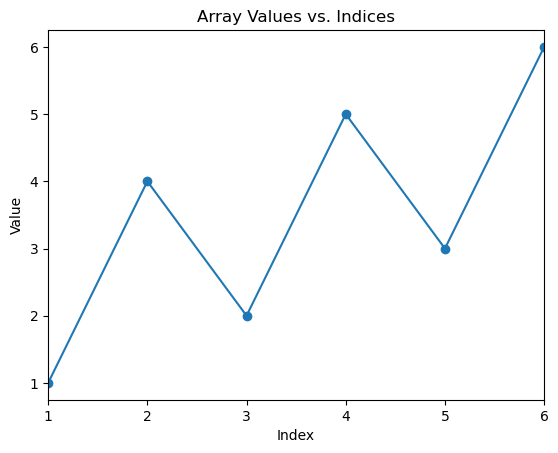

In [35]:


def plot_array(y):
    # Generate x values as indices of the array plus 1
    x = np.arange(len(y))+1

    # Plot the array
    plt.plot(x, y, marker='o')

    # Set the x-axis limits to ensure it spans from 1 to the length of the array
    plt.xlim(1, len(y))
    
    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Array Values vs. Indices')

    # Show the plot
    plt.show()

# Example usage
example_array = np.array([1, 4, 2, 5, 3, 6])
plot_array(example_array)


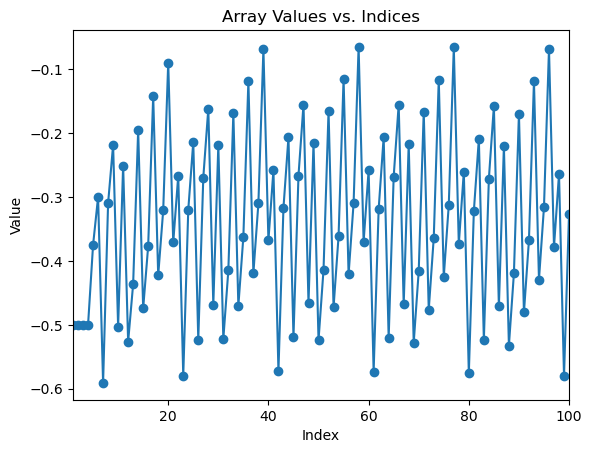

 No CCE discovered go home


In [64]:
plot_array(list_of_vals)
status = True
for v in list_of_vals:
    if v >= 0:
        print("CE discovered")
        status = False
if status:
    print(" No CCE discovered go home")

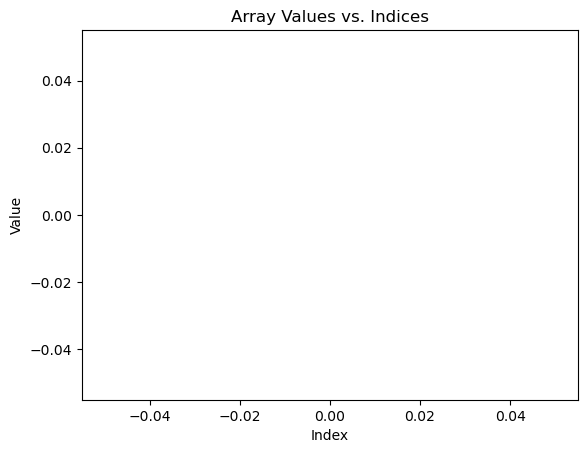

In [43]:
plot_array(list_of_vals)

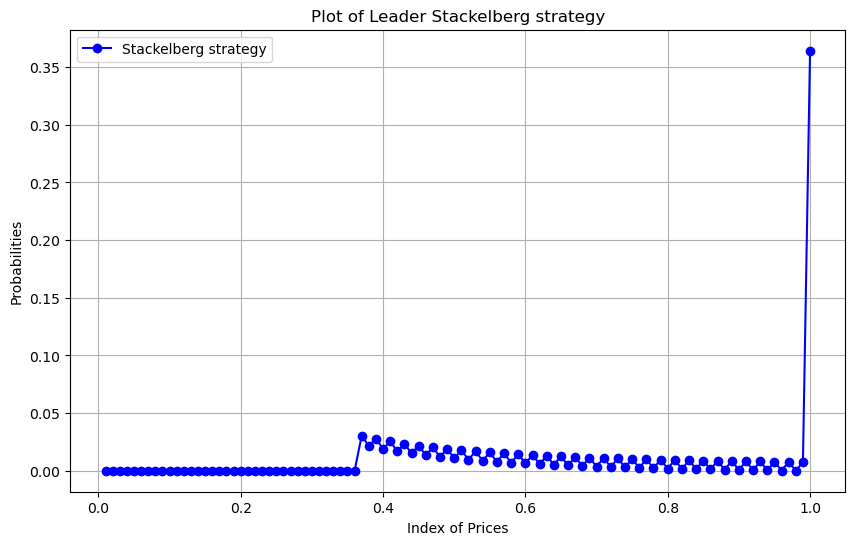

In [44]:
plt.figure(figsize=(10, 6))
#y = np.arange(100)
x = np.arange(1, len(best_leader_strategy_100) + 1)/100
plt.plot(x,best_leader_strategy, marker='o', linestyle='-', color='b', label='Stackelberg strategy')
plt.title('Plot of Leader Stackelberg strategy')
plt.xlabel('Index of Prices')
plt.ylabel('Probabilities')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
br_actions_follower = tied_best_responses(follower_matrix, best_leader_strategy)
print(br_actions_follower)

[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]


In [47]:
#from tqdm import tqdm

# Let's collect the leader and follower payoffs (and follower response) and plot them with increasing k
leader_payoffs = []
follower_payoffs = []
follower_responses = []

# Use tqdm to display progress
for k in range(1, 201):
    leader_matrix = build_payoff_matrix_row_player(k)
    follower_matrix = build_payoff_matrix_column_player(k)
    best_leader_payoff, best_leader_strategy, follower_response, follower_payoff = precise_stackelberg_equilibrium_print_flag(leader_matrix, follower_matrix)
    
    leader_payoffs.append(best_leader_payoff)
    follower_payoffs.append(follower_payoff)
    follower_responses.append(follower_response)


KeyboardInterrupt: 

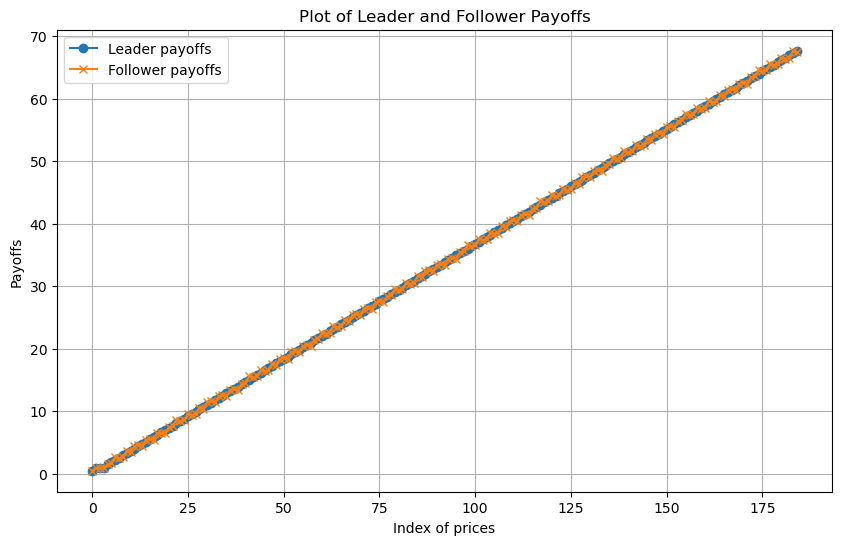

In [48]:

import matplotlib.pyplot as plt

# Assuming you have the lists list1 and list2


# Plotting the two lists
plt.figure(figsize=(10, 6))
plt.plot(leader_payoffs, label='Leader payoffs', marker='o')
plt.plot(follower_payoffs, label='Follower payoffs', marker='x')
plt.title('Plot of Leader and Follower Payoffs')
plt.xlabel('Index of prices')
plt.ylabel('Payoffs')
plt.legend()
plt.grid(True)
plt.show()


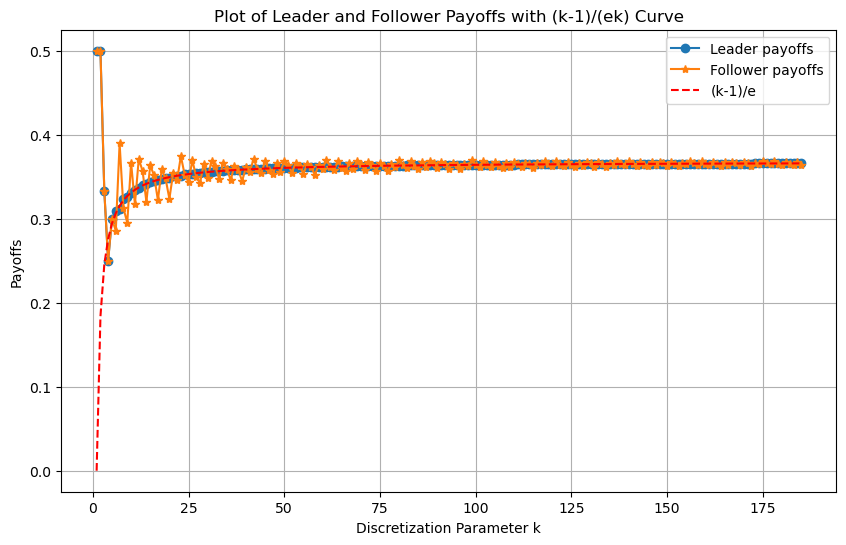

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the lists leader_payoffs and follower_payoffs
#leader_payoffs = [1, 2, 3, 4, 5]  # Example data, replace with your actual data
#follower_payoffs = [2, 3, 4, 5, 6]  # Example data, replace with your actual data

# Creating an x-axis range based on the length of your lists


leader_payoffs_normalized = [leader_payoffs[i] / (i + 1) for i in range(len(leader_payoffs))]
follower_payoffs_normalized = [follower_payoffs[i] / (i + 1) for i in range(len(follower_payoffs))]

x_values = np.arange(1, len(leader_payoffs) + 1)

# Computing the curve (x-1)/e
curve_values_1 = (x_values - 1) / (x_values * np.exp(1))

curve_values_2 = (x_values - 2) / np.exp(1)

curve_values = (x_values ) / np.exp(1)

# Plotting the two lists
plt.figure(figsize=(10, 6))
plt.plot(x_values, leader_payoffs_normalized, label='Leader payoffs', marker='o')
plt.plot(x_values, follower_payoffs_normalized, label='Follower payoffs', marker='*')

# Adding the (x-1)/e curve to the plot
plt.plot(x_values, curve_values_1, label='(k-1)/e', linestyle='--', color='red')
#plt.plot(x_values, curve_values_2, label='(k-2)/e', linestyle='--', color='purple')
#plt.plot(x_values, curve_values, label='(k)/e', linestyle='--', color='darkgreen')


# Adding labels, title, legend, and grid
plt.title('Plot of Leader and Follower Payoffs with (k-1)/(ek) Curve')
plt.xlabel('Discretization Parameter k')
plt.ylabel('Payoffs')
plt.legend()
plt.grid(True)

# Displaying the plot
plt.show()


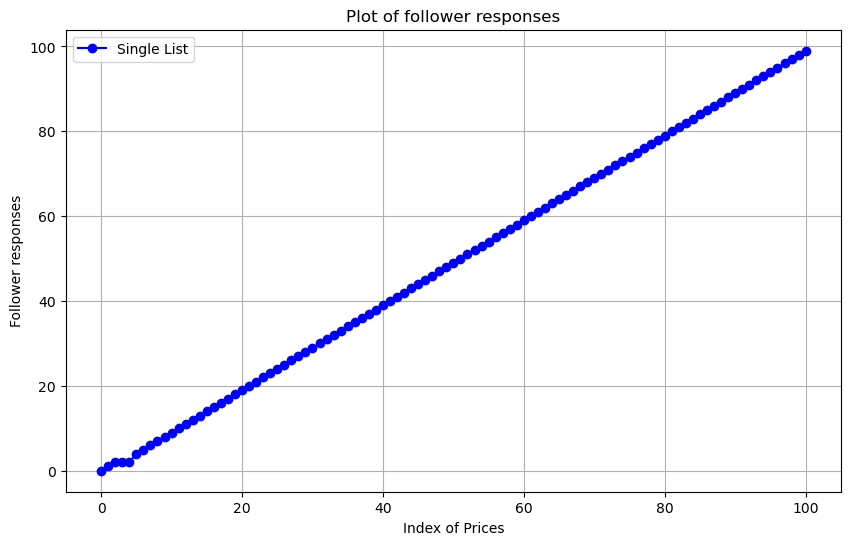

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(follower_responses, marker='o', linestyle='-', color='b', label='Single List')
plt.title('Plot of follower responses')
plt.xlabel('Index of Prices')
plt.ylabel('Follower responses')
plt.legend()
plt.grid(True)
plt.show()